In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from helper import *
import joblib

sns.set_theme(style="darkgrid")

### 📖 Data Cleaning Table of Contents

[__1. Data Loading__](#1-load-data)

[__2. Data Cleaning__](#2-clean-data)
- [2.1 Broken/ corrupted files](#21-broken-corrupted-files)
- [2.2 Duplicates detection by comparing dHash](#22-duplicates-detection-by-comparing-dhash-of-images)
- [2.3 Brightness anamolies detection](#23-detect-anamolies-by-comparing-brightness-in-grayscale)
- [2.4 Blurriness detection using Laplacian variance](#24-filter-out-extra-blurry-images-using-laplacian-variation)


### 1. Load Data

Extract age and gender labels from the file name.

In [3]:
root = "./data/full_dataset/"

# get a list of all file names in the root dir
full_files = os.listdir(root)

full_files = [i for i in full_files if i.endswith(".jpg")]

# get labels from the file names
full_files_labels_ls = [(i, "_".join(i.split("_")[:2])) for i in full_files]

full_df = pd.DataFrame(full_files_labels_ls, columns=["file_name", "label"])

full_df["file_name"] = full_df.file_name.apply(lambda x: "./data/full_dataset/" + x)

assert full_df.shape[0] == 23708

full_df.shape

(23708, 2)

These are multitask label for age and gender, separated by underscore: `age_gender`

0: male \
1: female

In [4]:
full_df.head(3)

file_name label
0  ./data/full_dataset/9_1_2_20161219204347420.jp...   9_1
1  ./data/full_dataset/36_0_1_20170117163203851.j...  36_0
2  ./data/full_dataset/86_1_0_20170120225751953.j...  86_1

### 2. Clean Data

##### 2.1 Broken/ corrupted files


In [68]:
broken_img_ls = detect_broken_images(full_df.file_name.tolist())
broken_img_ls = []
print(f"Total number of broken images: {len(broken_img_ls)}")

Total number of broken images: 0


##### 2.2 Duplicates detection by comparing [dHash](https://github.com/JohannesBuchner/imagehash) of images.

In [70]:
duplicated_img_df = compare_img_hash(file_name_ls)

print(f"{duplicated_img_df.shape[0]} duplicated images detected")

1207 duplicated images detected


__Are they real duplicates ?__ 

Using `difference image hash`, visually similar images can regarded as deplicates \
by mistake, let's take a closer look visually and only drop the real duplicates.

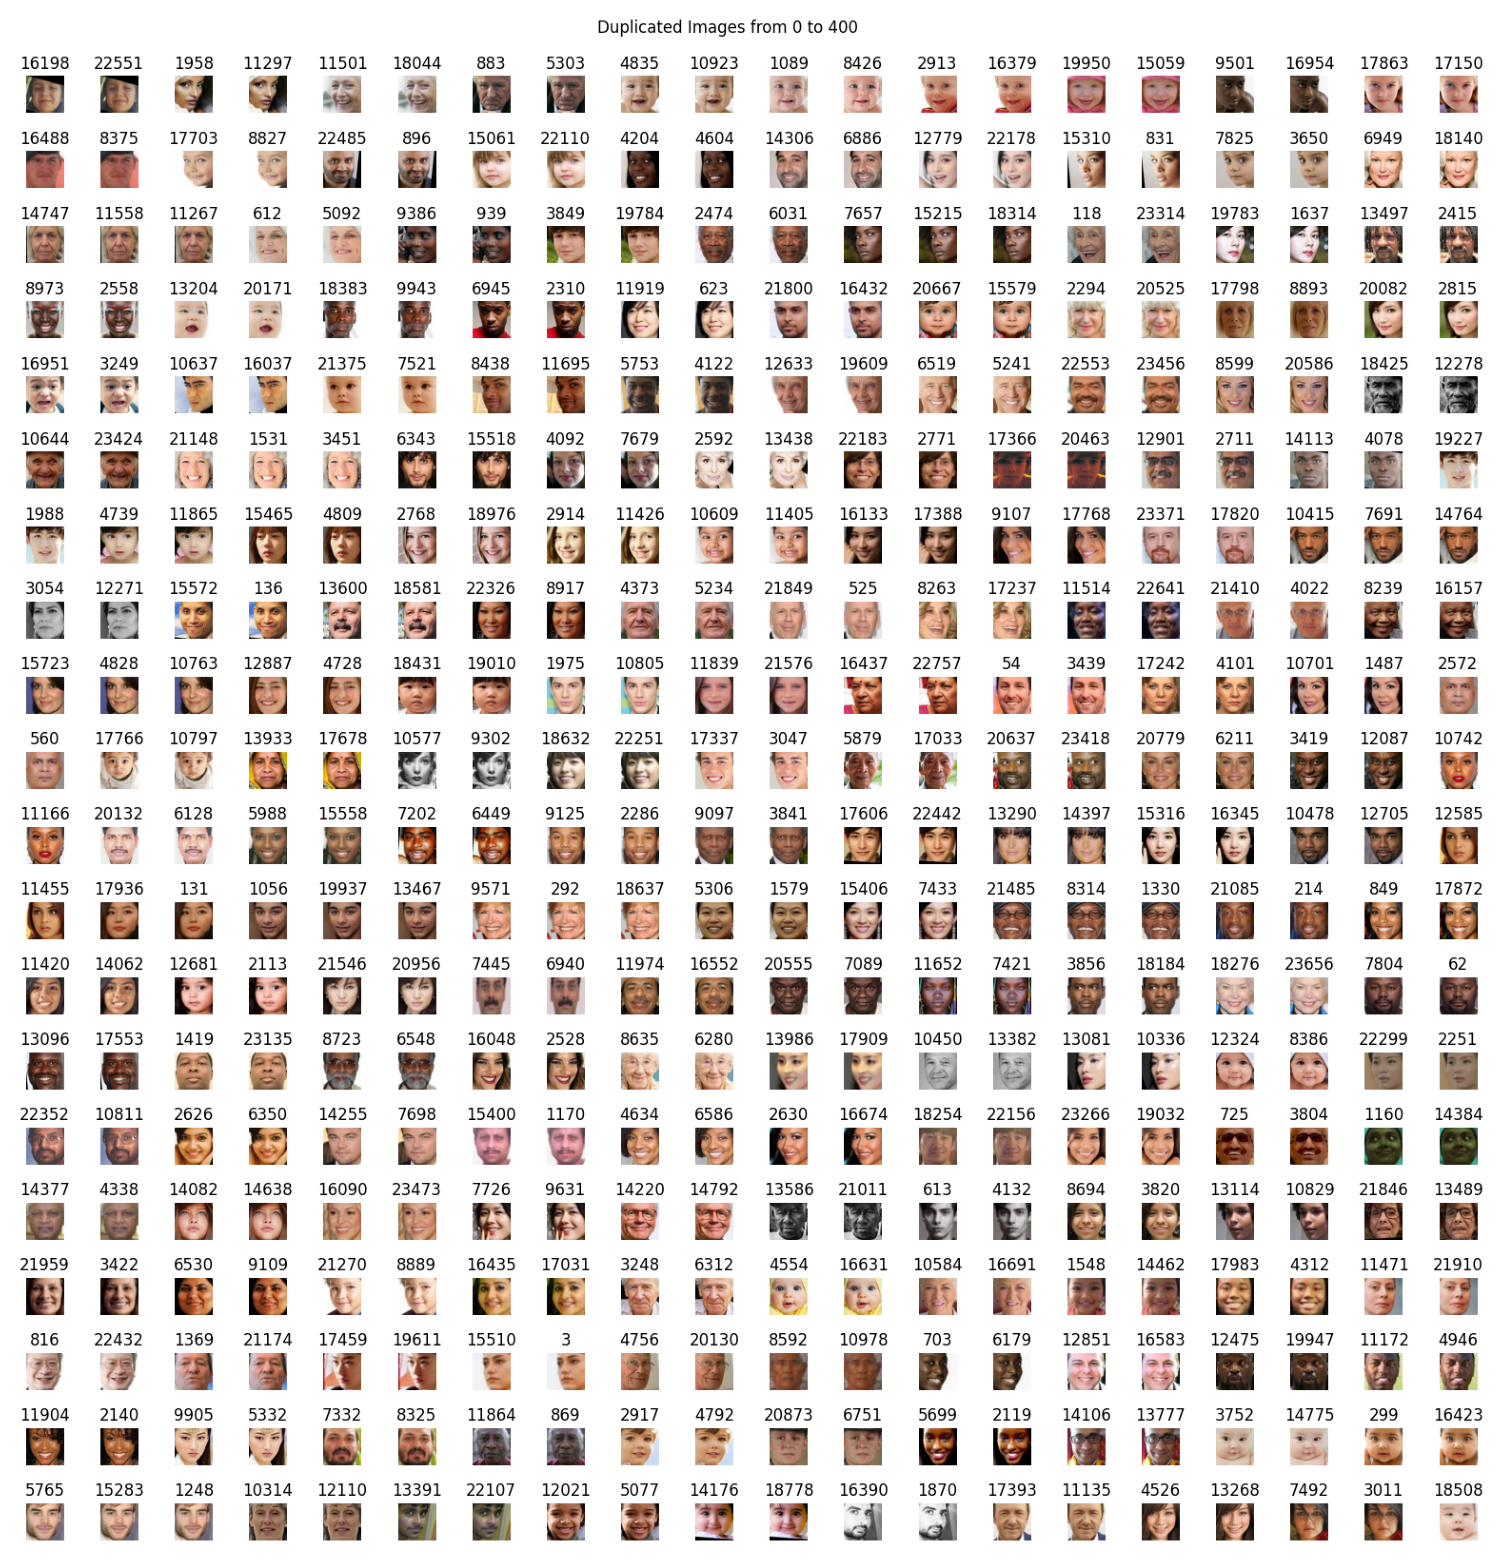

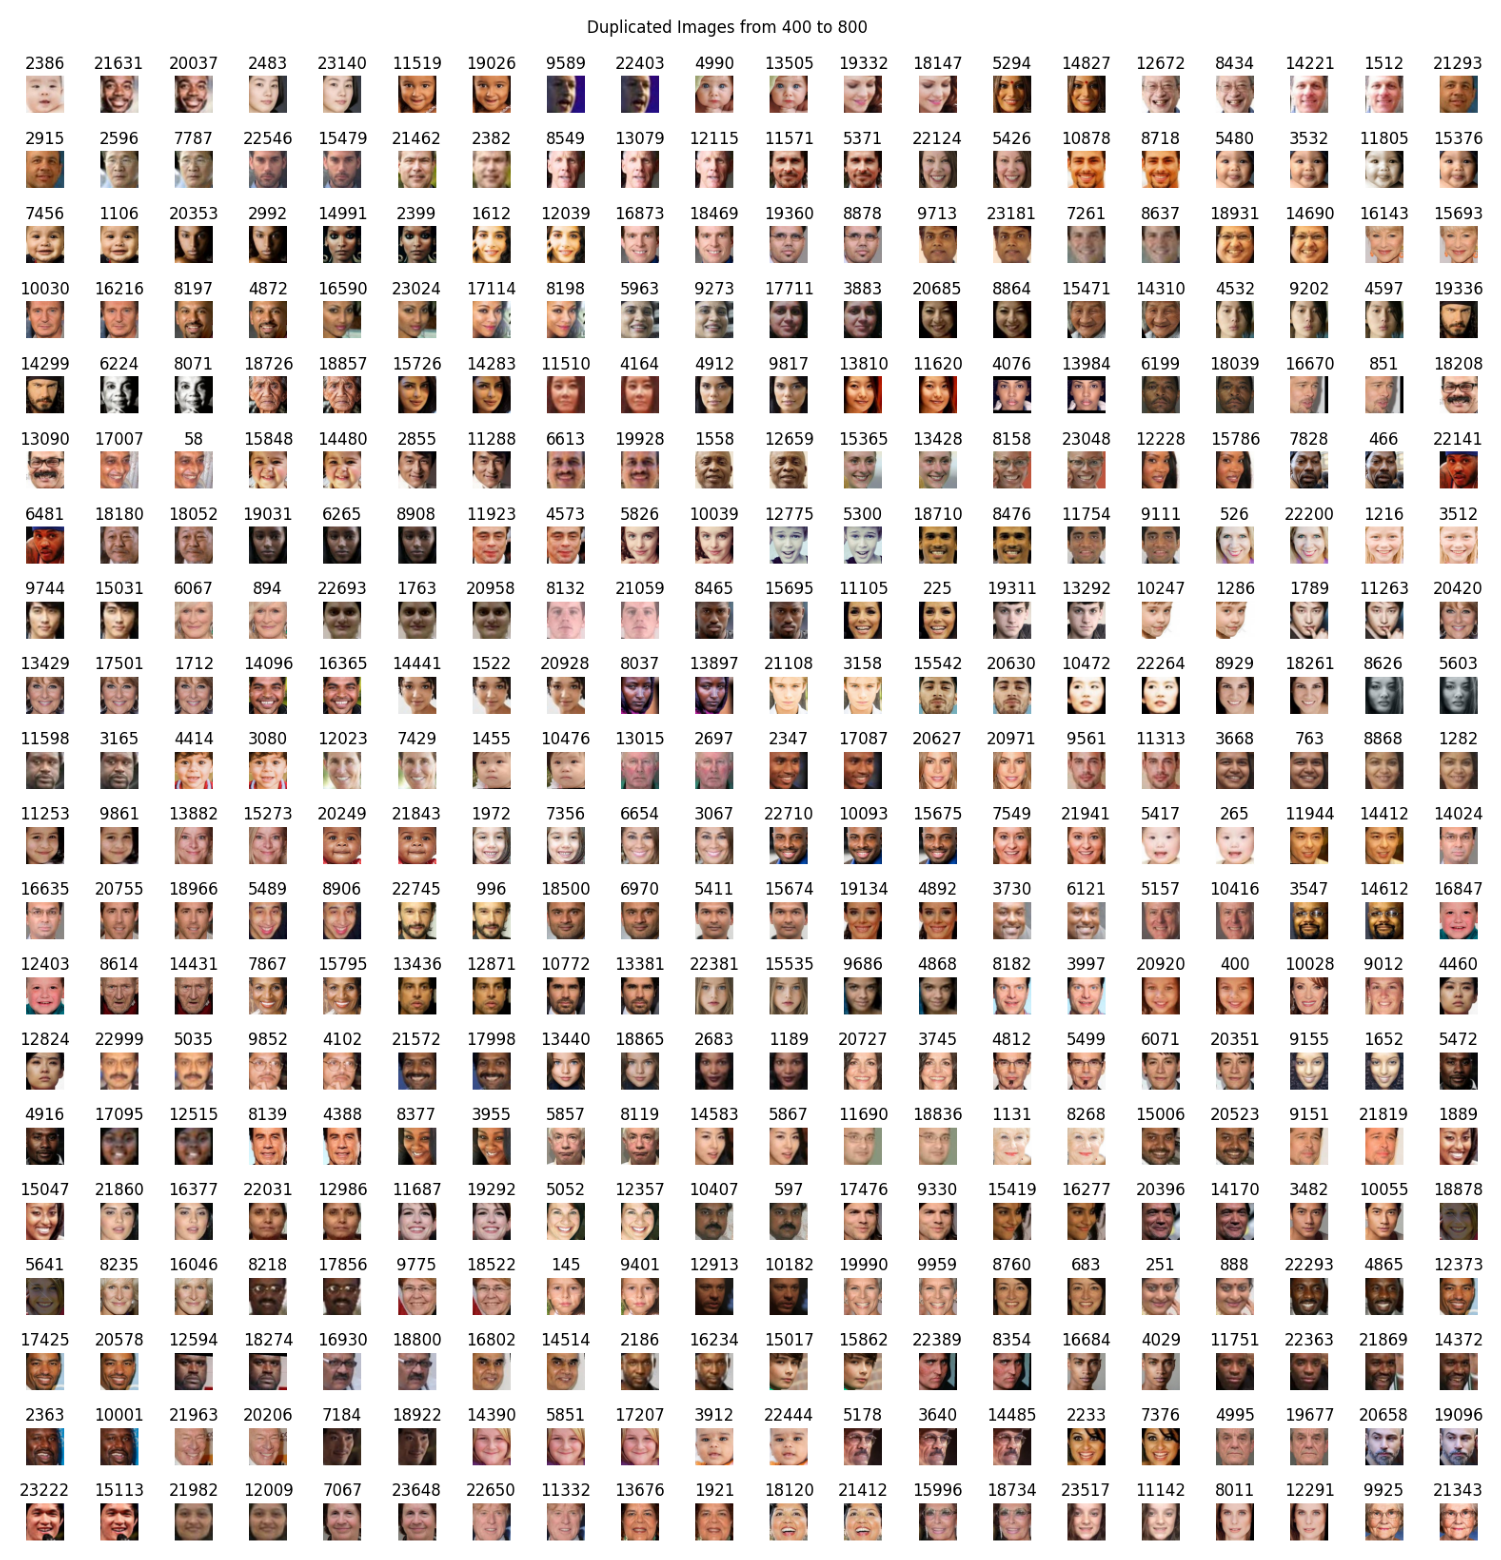

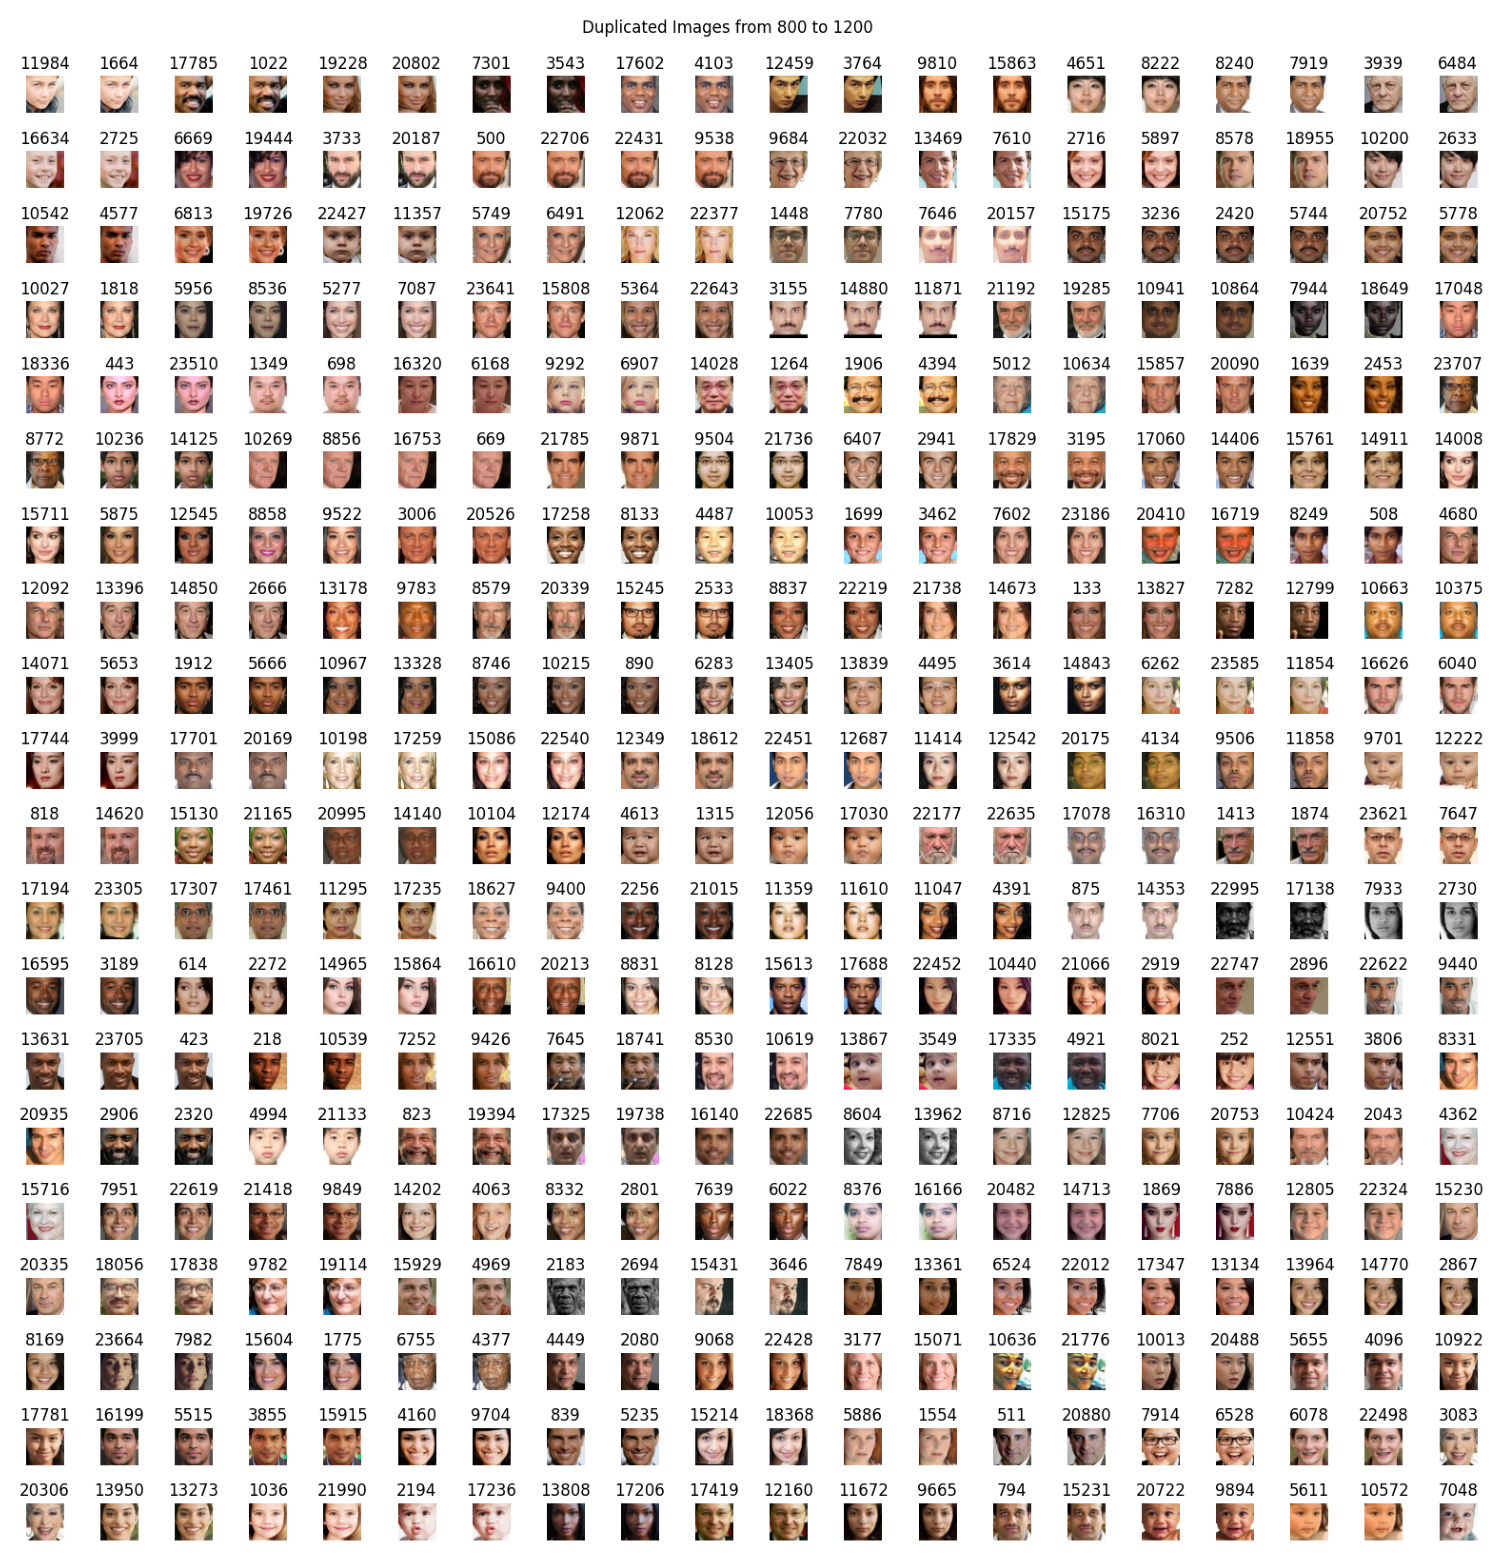

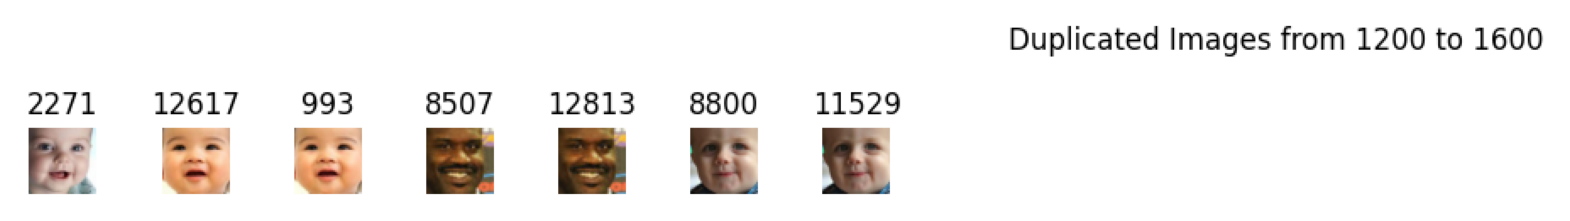

In [72]:
plot_duplicated_imgs(duplicated_img_df, (0, 400), "nb_caches/ddup_plt_1.png")
plot_duplicated_imgs(duplicated_img_df, (400, 800), "nb_caches/ddup_plt_2.png")
plot_duplicated_imgs(duplicated_img_df, (800, 1200), "nb_caches/ddup_plt_3.png")
plot_duplicated_imgs(duplicated_img_df, (1200, 1600), "nb_caches/ddup_plt_4.png")

After close inspection, I discovered 3 pairs of images beneath that are fasely \
marked as duplicates, they would not be dropped.

All the rest are real duplicates for 2~4 times, we would keep the first one and \
drop the rest.

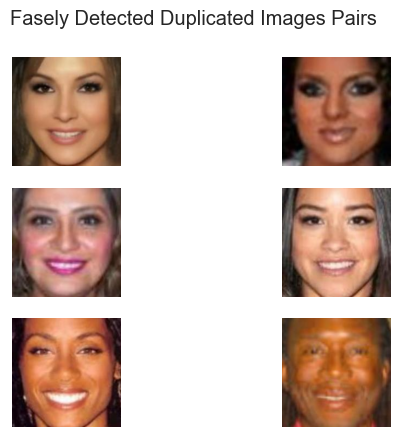

In [73]:
mis_dup = [5875, 12545, 8858, 9522, 13178, 9783]

n = 1
for i in mis_dup:
    file_name = duplicated_img_df[duplicated_img_df.index == i].file_name.values[0]
    plt.subplot(3, 2, n)
    plt.imshow(Image.open(file_name))
    plt.axis("off")

    n += 1

plt.suptitle("Fasely Detected Duplicated Images Pairs")
plt.show()

In [74]:
# preserve the misidentified duplicates
mis_dup_id = duplicated_img_df.loc[mis_dup].index.tolist()

file_name_ls = full_df.file_name.tolist()
# get the duplicates from full_df (keep = first)
total_dup_df = compare_img_hash(file_name_ls, dup_keep="first")
total_dup_id = total_dup_df.index.tolist()

# 618 real duplicates + 3 misidentified
assert total_dup_df.shape[0] == 621

# get the misidentified duplicates in the total duplicates
misidentified_dup_in_total_dup = list(set(mis_dup_id).intersection(total_dup_id))


# remove misidentified duplicates in the total duplicates
total_dup_df = total_dup_df.loc[
    ~total_dup_df.index.isin(misidentified_dup_in_total_dup)
]
total_dup_id = total_dup_df.index.tolist()

# 618 real duplicates
assert total_dup_df.shape[0] == 618

# drop duplicated images
full_df = full_df.loc[~full_df.index.isin(total_dup_id)]

assert full_df.shape[0] == 23090, "error after duplicate removal"

##### 2.3 Brightness anamolies detection

Images that are excessively dark or bright contain minimal information, it can \
create noise to the model and may indicate an error.

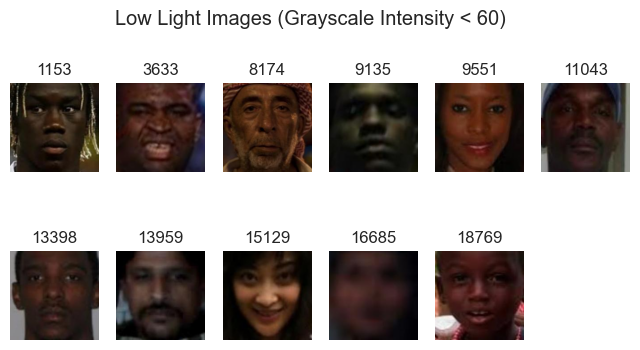

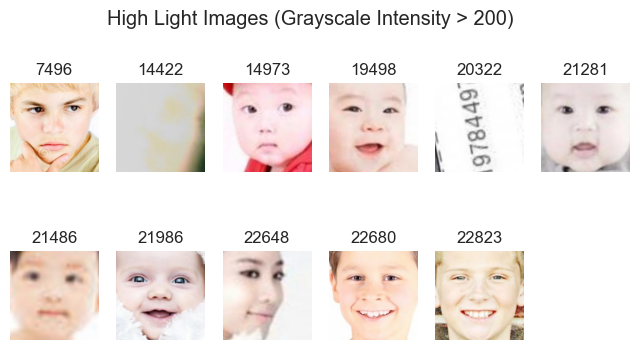

In [76]:
low_light_ls, high_light_ls = detect_light_anamolies(full_df, 60, 200, 80)

filename_id_dict = {v: k for k, v in full_df["file_name"].to_dict().items()}

fig_size(8, 4)
plot_img_ls(
    low_light_ls, filename_id_dict, 2, 6, "Low Light Images (Grayscale Intensity < 60)"
)
fig_size(8, 4)
plot_img_ls(
    high_light_ls,
    filename_id_dict,
    2,
    6,
    "High Light Images (Grayscale Intensity > 200)",
)

The threshold of low-light image is more challenging to decide on, using pixel- \
intensity < 60, we detected mainly dark-skinned people. Some images are taken \
under very low light + blurry.

I will remove the ones that are too blurred to even see a human form.
> remove 16685

We detected some clear non-face images in the high-light group. 
> remove 14422, 20322

Hight light images occur more in infant/toddler images.

In [77]:
light_anamolies_ls = [16685, 14422, 20322]

full_df = full_df.loc[~full_df.index.isin(light_anamolies_ls)]

assert full_df.shape[0] == 23087, "error after light anamolies removal"

##### 2.4 Blurriness detection using Laplacian variance

Laplacian variance is the second derivative of the pixel brightness.

In [79]:
blur_ls = detect_blurry_images(full_df, 5)
print(f"Number of blurry images: {len(blur_ls)}")

Number of blurry images: 37


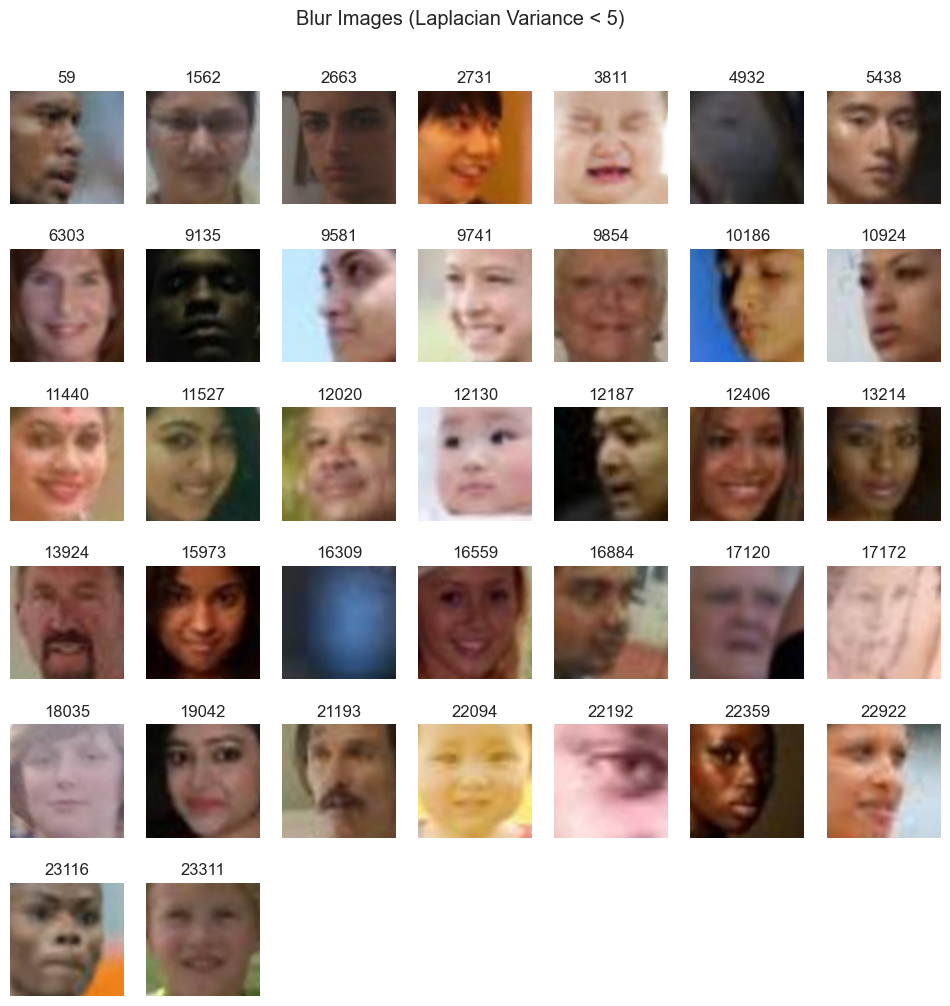

In [80]:
filename_id_dict = {v: k for k, v in full_df["file_name"].to_dict().items()}
fig_size(12, 12)
plot_img_ls(
    blur_ls,
    filename_id_dict,
    6,
    7,
    "Blur Images (Laplacian Variance < 5)",
    suptitle_y=0.94,
)

Although some images are rather blurry, it is still rather easy to tell the gender \
and have a good estimate of the age. 

We would remove images that are too close-up, no-human-form, deformed, too-blurry.

> remove: 4932, 9135, 16309, 17120, 17172, 22192

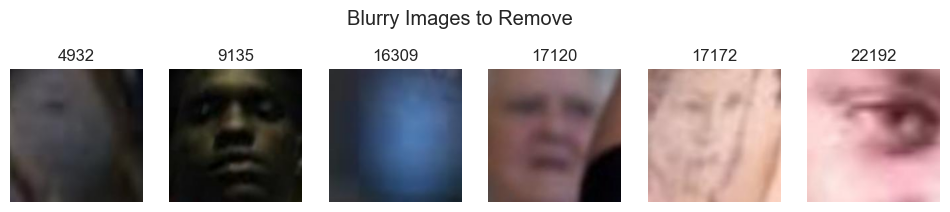

In [81]:
blur_remove_id = [4932, 9135, 16309, 17120, 17172, 22192]
blurr_remove_files = full_df.loc[full_df.index.isin(blur_remove_id)][
    "file_name"
].tolist()

fig_size(12, 2.5)
plot_img_ls(
    blurr_remove_files,
    filename_id_dict,
    1,
    6,
    "Blurry Images to Remove",
)

In [82]:
full_df = full_df.loc[~full_df.index.isin(blur_remove_id)]

assert full_df.shape[0] == 23081, "error after blur removal"

##### 2.5 Inspect and remove unused metadata

Some image has metadata attached which carries more info about the image, such \
as camera setting, geolocation...

We can inspect them in EDA or remove them if they are not interesting for us.

In [83]:
file_name_ls = full_df.file_name.tolist()

exif_ls = []
for file_name in file_name_ls:
    with Image.open(file_name) as img:
        exif_data = bool(img._getexif())
        exif_ls.append(exif_data)

print(f"Number of images with exif data: {sum(exif_ls)}")

Number of images with exif data: 0


There is no meta data for images in this dataset.

In [86]:
joblib.dump(full_df, "data/train_test_data/cleaned_full_df.pkl")

['data/train_test_data/cleaned_full_df.pkl']

💡 This is the end of data cleaning, continue to EDA in `2_eda.ipynb`